In [1]:
import numpy as np
import json
import os
import glob
import sys
from pprint import pprint
from matplotlib import pyplot as plt

from domainbed.lib import misc, reporting
from domainbed import datasets
from domainbed import algorithms
from domainbed.lib.query import Q
from domainbed.model_selection import IIDAccuracySelectionMethod, OracleSelectionMethod

# Arguments

In [2]:
base_output_dir="./checkpoints"

dataset_all = ['PACS', 'VLCS', 'OfficeHome', 'TerraIncognita', 'DomainNet']
algorithm_all = {'CondCAD': 'CondCAD'}

select_method = OracleSelectionMethod

# Helper Functions

In [3]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
             pretty(value, indent+1)
        else:
             print('\t' * (indent+1) + str(value))

def get_record(output_dir):
    print("Loading records from:", output_dir)
    records = reporting.load_records(output_dir)
    print("Total records:", len(records))

    return records

def get_results(out_dir, selection_method):
    """Given all records, print a results table for each dataset."""
    records = get_record(out_dir)
    
    grouped_records = reporting.get_grouped_records(records,
                                                    group_test_envs=True).map(
        lambda group:
        {**group, "sweep_acc": selection_method.sweep_acc(group["records"], return_extra=True)}
        ).filter(lambda g: g["sweep_acc"] is not None)

    # read algorithm names and sort (predefined order)
    alg_names = Q(records).select("args.algorithm").unique()
    assert len(alg_names) == 1
    algorithm = alg_names[0]

    # read dataset names and sort (lexicographic order)
    dataset_names = Q(records).select("args.dataset").unique().sorted()
    assert len(dataset_names) == 1
    dataset = dataset_names[0]

    trial_averages = (grouped_records
                      .filter_equals("algorithm, dataset", (algorithm, dataset))
                      .group("trial_seed")
                      .map(lambda trial_seed, group:
#                            group.select("sweep_acc").mean()
                           tuple(map(lambda y: sum(y) / float(len(y)), zip(*group.select("sweep_acc"))))
                           )
                      )
    
    tgt_all, src_all, tgt_in_all = zip(*trial_averages) 
    tgt_mean, src_mean, tgt_in_mean = 100 * np.mean(list(tgt_all)), 100 * np.mean(list(src_all)), 100 * np.mean(list(tgt_in_all))
    tgt_std, src_std, tgt_in_std = 100 * np.std(list(tgt_all)), 100 * np.std(list(src_all)), 100 * np.std(list(tgt_in_all))
    
    return (tgt_mean, src_mean, tgt_in_mean), (tgt_std, src_std, tgt_in_std)

# Get Results

Gollect result dict for each setup:

In [4]:
def get_result(setup):
    result_dict = {}
    for dataset in dataset_all:
        result_dict[dataset] = {}
        sub_result_dict = result_dict[dataset]
        basedir = f'{base_output_dir}/{dataset}/{setup}'

        for alg_name, alg_name_long in algorithm_all.items():
            if alg_name in ['CLIPPretrained', 'CLIPBase']:
                sub_result_dict[alg_name] = {}
                subsub_result_dict = sub_result_dict[alg_name]

                output_dir = os.path.join(basedir, f'{alg_name_long}/base')
                print(output_dir)
                (acc_tgt, acc_src, acc_tgt_in), (acc_tgt_std, acc_src_std, acc_tgt_in_std) = get_results(output_dir, select_method)
                subsub_result_dict['acc_tgt'] = acc_tgt
                subsub_result_dict['acc_src'] = acc_src
                subsub_result_dict['acc_tgt_in'] = acc_tgt_in
                subsub_result_dict['acc_diff'] = acc_src - acc_tgt
                subsub_result_dict['acc_tgt_std'] = acc_tgt_std
                subsub_result_dict['acc_src_std'] = acc_src_std
                subsub_result_dict['acc_tgt_in_std'] = acc_tgt_in_std
            else:
                lambda_str_array = list(map(lambda s: s.split('_')[-1], glob.glob(os.path.join(basedir, f'{alg_name_long}/*'))))
                lambda_str_array = sorted(lambda_str_array, key=lambda r: float(r))
                lambda_val_array = np.array(list(map(lambda s: float(s), lambda_str_array)))

                for lambda_str in lambda_str_array:
                    sub_result_dict[alg_name + '_lambda_{}'.format(lambda_str)] = {}
                    subsub_result_dict = sub_result_dict[alg_name + '_lambda_{}'.format(lambda_str)]
                    output_dir = os.path.join(basedir, f'{alg_name_long}/lambda_{lambda_str}')

                    (acc_tgt, acc_src, acc_tgt_in), (acc_tgt_std, acc_src_std, acc_tgt_in_std) = get_results(output_dir, select_method)


                    subsub_result_dict['acc_tgt'] = acc_tgt
                    subsub_result_dict['acc_src'] = acc_src
                    subsub_result_dict['acc_tgt_in'] = acc_tgt_in
                    subsub_result_dict['acc_diff'] = acc_src - acc_tgt
                    subsub_result_dict['acc_tgt_std'] = acc_tgt_std
                    subsub_result_dict['acc_src_std'] = acc_src_std
                    subsub_result_dict['acc_tgt_in_std'] = acc_tgt_in_std
                    
    return result_dict


In [5]:
result_dict = get_result('e2e_dombed')

Loading records from: ./checkpoints/PACS/e2e_dombed/CondCAD/lambda_0


Total records: 4350
Loading records from: ./checkpoints/PACS/e2e_dombed/CondCAD/lambda_1e-5


Total records: 4357
Loading records from: ./checkpoints/VLCS/e2e_dombed/CondCAD/lambda_0


Total records: 4736
Loading records from: ./checkpoints/VLCS/e2e_dombed/CondCAD/lambda_1e-5


Total records: 4418
Loading records from: ./checkpoints/OfficeHome/e2e_dombed/CondCAD/lambda_0


Total records: 4329
Loading records from: ./checkpoints/OfficeHome/e2e_dombed/CondCAD/lambda_1e-5


Total records: 4358
Loading records from: ./checkpoints/TerraIncognita/e2e_dombed/CondCAD/lambda_0


Total records: 4356
Loading records from: ./checkpoints/TerraIncognita/e2e_dombed/CondCAD/lambda_1e-5


Total records: 4332
Loading records from: ./checkpoints/DomainNet/e2e_dombed/CondCAD/lambda_0


Total records: 315
Loading records from: ./checkpoints/DomainNet/e2e_dombed/CondCAD/lambda_1e-5


Total records: 341


In [6]:
pretty(result_dict)

PACS
	CondCAD_lambda_0
		acc_tgt
			86.33591410627369
		acc_src
			95.16513704448127
		acc_tgt_in
			86.33591410627369
		acc_diff
			8.829222938207579
		acc_tgt_std
			0.6791788822747292
		acc_src_std
			0.45871507040448006
		acc_tgt_in_std
			0.6791788822747292
	CondCAD_lambda_1e-5
		acc_tgt
			86.55205805186893
		acc_src
			95.08893459917446
		acc_tgt_in
			86.55205805186893
		acc_diff
			8.536876547305539
		acc_tgt_std
			0.9810885154184971
		acc_src_std
			0.8578185763711921
		acc_tgt_in_std
			0.9810885154184971
VLCS
	CondCAD_lambda_0
		acc_tgt
			77.41422831677936
		acc_src
			83.34467023367367
		acc_tgt_in
			77.41422831677936
		acc_diff
			5.93044191689431
		acc_tgt_std
			0.43339674909050313
		acc_src_std
			1.0809741926668301
		acc_tgt_in_std
			0.43339674909050313
	CondCAD_lambda_1e-5
		acc_tgt
			78.04251944509234
		acc_src
			83.7188189021876
		acc_tgt_in
			78.04251944509234
		acc_diff
			5.6762994570952685
		acc_tgt_std
			0.298538031227598
		acc_src_std
			0.80083625503

# Plot & Analysis

In [7]:
def plot_result(result_dict, plot_dataset, plot_y='acc_tgt', include=None, exclude=None, plot_std=False):
    plt.figure()
    sub_result_dict = result_dict[plot_dataset]
    plt_xs = []
    plt_ys = []
    plt_errs = []
    
    for k, v in sub_result_dict.items():
        subsub_result_dict = sub_result_dict[k]
        
        if include is not None and k not in include:
            continue
            
        if exclude is not None and k in exclude:
            continue
            
        plt_xs.append(k.replace('_', '\n'))
        plt_ys.append(subsub_result_dict[plot_y])
        plt_errs.append(subsub_result_dict[plot_y + '_std'])
    
    
    if not plot_std:
        plt.bar(plt_xs, plt_ys)
    else:
        plt.bar(plt_xs, plt_ys, yerr=plt_errs)
    
    for plt_x, plt_y, plt_err in zip(plt_xs, plt_ys, plt_errs):
        plt.text(plt_x, plt_y + .25, '{:.1f} +/- {:.1f}'.format(plt_y, plt_err) , color='blue', fontweight='bold')
            
    
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.ylim([np.min(plt_ys)-0.5, np.max(plt_ys)+0.5])
        
    plt.show()

Visualize the results. Note that the results may be slightly different from the paper due to code cleaning. 

Note that as the claim of our paper, the algorithms in this setup lack access to the information of the target domain, so we don't expect our bottlenecks and other algorithms to necessarily outperform ERM.

However, we surprisingly find training our CAD bottleneck (lambda = 1e-5) does lead to consistent improvement over training without (lambda = 0).

## VLCS

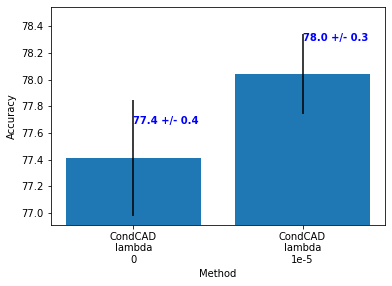

In [9]:
plot_result(result_dict, plot_dataset='VLCS', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

## PACS

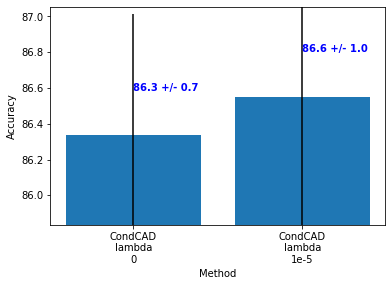

In [8]:
plot_result(result_dict, plot_dataset='PACS', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

## OfficeHome

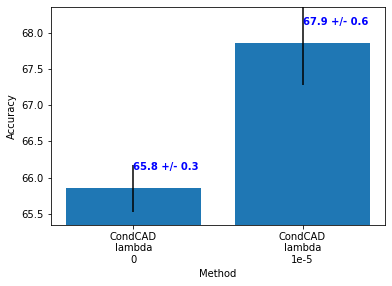

In [10]:
plot_result(result_dict, plot_dataset='OfficeHome', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

## TerraIncognita

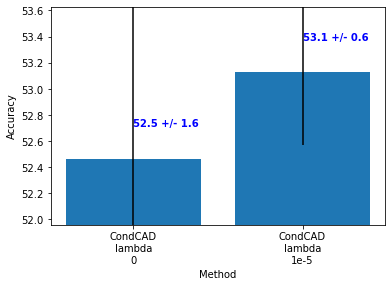

In [11]:
plot_result(result_dict, plot_dataset='TerraIncognita', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

# DomainNet

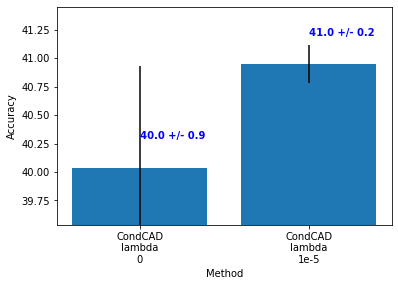

In [12]:
plot_result(result_dict, plot_dataset='DomainNet', plot_y='acc_tgt', 
            exclude=None, plot_std=True)